In [1]:
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import math
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.ticker as ticker
%matplotlib inline

In [2]:
data = np.load("data/DK_time_series_3000000.npy")

train = data[:-500000]
test =  data[-500000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [3]:
def amp_to_int(x, n=256):
    ### x.min must be negative
    step = (x.max() - x.min()) / n
    ans = np.zeros_like(x)
    for i, val in enumerate(np.arange(x.min(), x.max(), step)):
        for j in range(len(x)):
            if val <= x[j] < val + step:
                ans[j] = i
                
    return ans


def int_to_amp(x, x_true, n=256):
    ### x.min must be negative
    step = (x_true.max() - x_true.min()) / n
    ans = np.zeros_like(x, dtype=float)
    #for j in range(len(x)):
    ans = x_true.min() + x * step
                
    return ans        
    

In [4]:
int_data = amp_to_int(data)
train = int_data[:-500000]
test = int_data[-500000:]

In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
    
        return x + self.pe[:x.size(0), :]
          

class TransAm(nn.Module):
    def __init__(self,feature_size=256, nhead=8, num_layers=2,dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,256)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask
        
        #print(src.size())
        src = self.pos_encoder(src)
        #print(src.size())

        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        #print(output.size())
        
        output = self.decoder(output)
        #print(output.size())
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [6]:
model_trans = TransAm().to('cuda')

In [7]:
input_window = 20
batch_size = 64

In [8]:
def one_hot(x, num_channels=256, device='cuda'):
    x_o = torch.FloatTensor(x.shape[0], num_channels, x.shape[1])
    x_o = x_o.to(device)
    x_o.zero_().scatter_(1, x.unsqueeze(1), 1)
    return x_o

In [9]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    input_data = torch.LongTensor(input_data)
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+1:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train, train_window)
test_inout_seq = create_inout_sequences(test, train_window)

In [10]:
def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target

In [11]:
len(train) / batch_size

39062.5

In [17]:
def run_epoch(model, train_data, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        if is_training:
            optimizer.zero_grad()
            
        #print(data.size())
        #print(y.size())
        #x = torch.transpose(x, 0, 1).reshape((20, 10, 1)).float().to('cuda')
        #y = y.view(-1).float().to('cuda')

        #out = model(data.to('cuda'))
        #loss = criterion(out, targets.to('cuda'))
                
        
        if data.size()[1] < 64: 
            break
        data = torch.reshape(data, (64, 20)).to('cuda')

        x_o = one_hot(data)
        
#         y = y.type(torch.LongTensor)
#         y = y.view(-1).to('cuda')
        


        out = model(x_o.permute(0, 2, 1))
        #targets= targets.view(-1).to('cuda')
        #targets = targets.permute(1, 0, 2).to('cuda')
        #print(out.size())
        #print(targets.size())
        #loss = criterion(out, targets)
        output_v = out.view(-1,out.shape[-1])
        target_v = targets.to('cuda').view(-1,1).squeeze()
        loss = criterion(output_v, target_v)
#         loss = 0
        
#         for i in range(train_window):
#              loss = criterion(out[:, i, :], targets[i, :, 0].to('cuda'))
        

        if is_training:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
            optimizer.step()

        epoch_loss += (loss.detach().item() / batch_size)

    #lr = scheduler.get_last_lr()[0]

    return epoch_loss

In [24]:
model_trans.load_state_dict(torch.load("./TransformerLargeBin26.04"))

<All keys matched successfully>

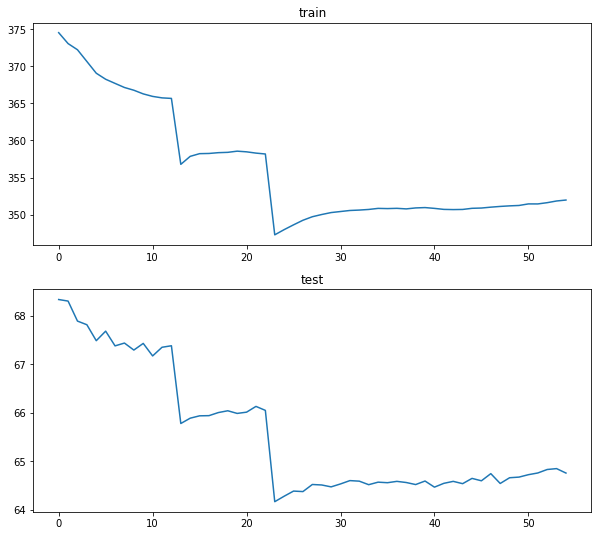

 28%|████████████████████▋                                                      | 55/200 [6:24:07<16:03:40, 398.76s/it]

Epoch[55/200] | loss train:351.982141, test:64.753432


 28%|████████████████████▋                                                      | 55/200 [6:29:38<17:07:13, 425.06s/it]


KeyboardInterrupt: 

In [25]:
criterion = nn.CrossEntropyLoss()
lr = 0.001 
optimizer = optim.Adam(model_trans.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
#scheduler = optim.lr_scheduler.StepLR(optimizer,  1.0, gamma=0.95)

losses_train = []
losses_test = []
best_loss = 1e9
# begin training
for epoch in tqdm(range(200)):
    loss_train = run_epoch(model_trans, train_inout_seq, is_training=True)
    loss_val = run_epoch(model_trans, test_inout_seq)
    #scheduler.step()
    optimizer = optim.Adam(model_trans.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    if epoch > 10:
        lr = 0.0005
        
    if epoch > 20:
        lr = 0.0001
    
    if losses_test[-1] < best_loss:
        best_loss = losses_test[-1]
        torch.save(model_trans.state_dict(), "./TransformerLargeBin26.04cont")
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val))

In [11]:
def GetRmseTransformer(model, test_inout_seq, k=19):
    model.eval()
    

    rmse = []
    transformer_predicts = []
    all_predicts = np.empty((k, 1))
    
    for batch, i in tqdm(enumerate(range(0, len(test_inout_seq) - 1, batch_size))):
        data, targets = get_batch(test_inout_seq, i,batch_size)
        if data.size()[1] < 64:
                break
        all_predicts = np.concatenate((all_predicts, np.zeros((k, 64))), axis=1)
        x = torch.reshape(data, (64, 20, 1))
        cur_x = x
        for step in range(k):
            x_step = cur_x.type(torch.LongTensor)
            x_step = torch.reshape(x_step, (64, 20)).to('cuda')
            x_o = one_hot(x_step)
            out = model(x_o.permute(0, 2, 1))
            #print(out.size())
            all_predicts[step, -64:] = np.argmax(out[:, -1, :].detach().cpu(), axis=1)
            cur_x = torch.hstack((cur_x[:, 1:].detach(), 
                                  torch.reshape(np.argmax(out[:, -1, :].detach().cpu(), axis=1), (64, 1, 1))))
    
#     for step in tqdm(range(1, k+1)):
#         test_right_part = (len(test)- 20)%64
#         predicted_val = np.array([])
#         for batch, i in enumerate(range(0, len(test_inout_seq) - 1, batch_size)):
#             all_predicts = np.concatenate((all_predicts, np.zeros((k, 64))), axis=1)
#             data, targets = get_batch(test_inout_seq, i,batch_size)
#             if data.size()[1] < 64:
#                 break
#             cur_x = data
#             for _ in range(step):
#                 x_step = cur_x.type(torch.LongTensor)
#                 x_step = torch.reshape(x_step, (64, 20))
#                 x_o = one_hot(x_step, device="cpu")
#                 out = model(x_o.permute(0, 2, 1))
#                 all_predicts[step, -64:] = np.argmax(out.detach(), axis=1)
#                 cur_x = torch.hstack((cur_x[:, 1:].detach(), 
#                                   torch.reshape(np.argmax(out.detach(), axis=1), (64, 1, 1))))
#                 #out = model(cur_x.to('cuda'))
#                 #cur_x = torch.hstack((cur_x[:, 1:], out.cpu()))
#                 #cur_x = torch.vstack((cur_x[1:, :], out[-1].cpu().reshape((1, 64, 1))))
#             #out = model1(cur_x.to('cuda'))
#             #predicted_val = np.concatenate((predicted_val, out[-1, :, 0].cpu().detach().numpy()))
#             #predicted_val = np.concatenate((predicted_val, cur_x[-1, :, 0].cpu().detach().numpy()))
            
#         transformer_predicts.append(np.array(predicted_val)*std+mean)
        
#         if k == 1:
#             r = (((np.array(predicted_val)*std+mean - np.array(test[20:-test_right_part]))**2).mean())**0.5
#         else:
#             r = (((np.array(predicted_val[:-k+1])*std+mean - np.array(test[20+k-1:-test_right_part]))**2).mean())**0.5
#         rmse.append(r)
    return all_predicts

In [13]:
model_trans.load_state_dict(torch.load("./TransformerLargeBin26.04cont"))

<All keys matched successfully>

In [14]:
predicts = GetRmseTransformer(model_trans.to('cuda'), test_inout_seq)

7812it [12:22, 10.53it/s]


In [26]:
#np.save("transformer_bin_predicts.npy", predicts)

In [29]:
#np.save("transformer_bin_predicts27_04.npy", predicts)

In [5]:
transformer_rmse_cont = np.load("predicts/transformer_rmse.npy")

In [49]:
predicts = np.load("transformer_bin_predicts.npy")

In [50]:
def CalcRMSE(x, y):
    return (((x - y)**2).mean())**0.5

In [51]:
test_right_part = (len(test)- 20)%64
trans_rmses_bin = []
trans_rmses_bin.append(CalcRMSE(int_to_amp(predicts[0][1:], data), test[20:-test_right_part]))
for i in tqdm(range(1, 19)):
    trans_rmses_bin.append(CalcRMSE(int_to_amp(predicts[i][1:], data, n=256)[:-i], test[20+i: -test_right_part]))

100%|█████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 100.59it/s]


In [55]:
np.save('predicts/trans_rmses_bin.npy', trans_rmses_bin)

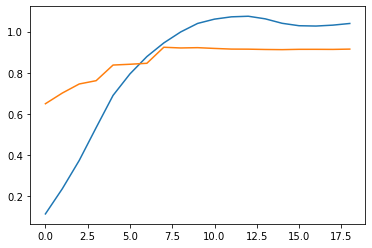

In [54]:
plt.plot(transformer_rmse_cont)
plt.plot(trans_rmses_bin)

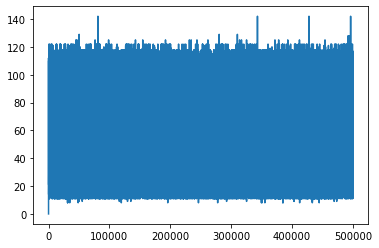

In [38]:
plt.plot(predicts[18])

In [21]:
len(predicts)

19

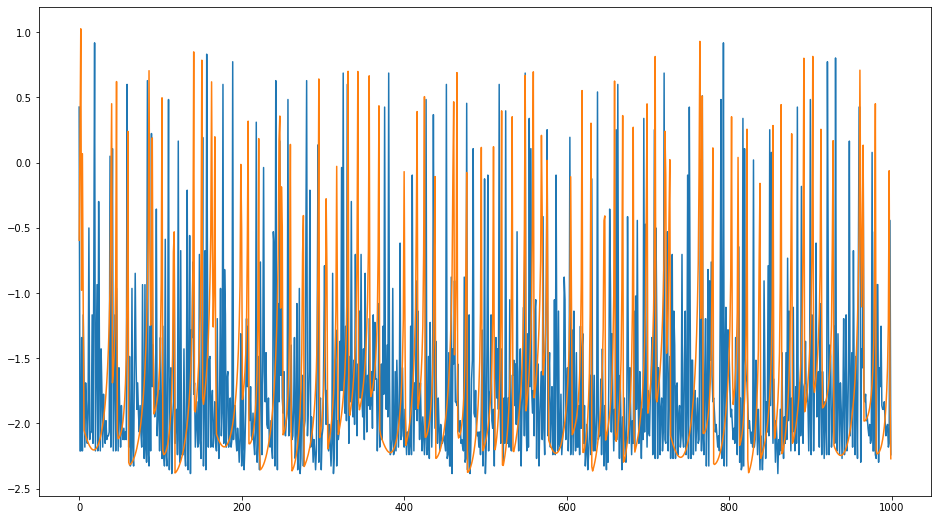

In [45]:
plt.figure(figsize=(16, 9))
i=0
plt.plot(int_to_amp(predicts[i][1:], data)[:1000])
plt.plot(test[20+i:1020+i])